# Real world example

In this example, I'm going to show you how to use RLTK to solve a real problem.

## Problem & Dataset analysis

The data we used here is called Abt-Buy, which can be found [here](https://github.com/usc-isi-i2/rltk-experimentation/tree/master/datasets/Abt-Buy). Abt.com (Abt.csv) and Buy.com (Buy.csv) are two e-commerce retailers, the goal is to find all matches (abt_buy_perfectMapping.csv) of products between these two files.

Let's take a look of these files first. `wc`, `less` and `grep` are great tools to start with, then `pandas` or other data analysis tools / libraries can tell you more detailed information. Here's what I will do:

In [1]:
# initialization
import os
import pandas as pd
from IPython.display import display

# find rltk-experimentation
def find_file_path(from_dir, file_path, depth=5):
    if depth == 0:
        raise RecursionError('Maximum recursion depth exceeded')
    path = os.path.join(from_dir, file_path)
    if os.path.exists(path):
        return path
    return find_file_path(os.path.join(from_dir, '..'), file_path, depth-1)
os.chdir(find_file_path(os.getcwd(), 'rltk-experimentation'))

In [2]:
def print_stats(fp):
    print(fp)
    df_data = pd.read_csv(fp, encoding='latin-1')
    
    print('\nfirst 5 rows:')
    display(df_data.head(5))
    
    stat = []
    for i in range(df_data.shape[1]):
        stat.append(df_data.shape[0] - df_data.iloc[:,i].isnull().sum())
    df_stat = pd.DataFrame([stat], columns=df_data.columns.values.tolist())
    df_stat.rename(index={0: 'total'}, inplace=True)
    print('\ntotal number of rows:')
    display(df_stat.head(1))
    print('\n')
    
print_stats('datasets/Abt-Buy/abt.csv')
print_stats('datasets/Abt-Buy/buy.csv')
print_stats('datasets/Abt-Buy/abt_buy_perfectMapping.csv')

datasets/Abt-Buy/abt.csv

first 5 rows:


,id,name,description,price
0,552,Sony Turntable - PSLX350H,Sony Turntable - PSLX350H/ Belt Drive System/ ...,NaN
1,580,Bose Acoustimass 5 Series III Speaker System -...,Bose Acoustimass 5 Series III Speaker System -...,$399.00
2,4696,Sony Switcher - SBV40S,Sony Switcher - SBV40S/ Eliminates Disconnecti...,$49.00
3,5644,Sony 5 Disc CD Player - CDPCE375,Sony 5 Disc CD Player- CDPCE375/ 5 Disc Change...,NaN
4,6284,Bose 27028 161 Bookshelf Pair Speakers In Whit...,Bose 161 Bookshelf Speakers In White - 161WH/ ...,$158.00



total number of rows:


,id,name,description,price
total,1081,1081,1081,418




datasets/Abt-Buy/buy.csv

first 5 rows:


,id,name,description,manufacturer,price
0,10011646,Linksys EtherFast EZXS88W Ethernet Switch - EZ...,Linksys EtherFast 8-Port 10/100 Switch (New/Wo...,LINKSYS,NaN
1,10140760,Linksys EtherFast EZXS55W Ethernet Switch,5 x 10/100Base-TX LAN,LINKSYS,NaN
2,10221960,Netgear ProSafe FS105 Ethernet Switch - FS105NA,NETGEAR FS105 Prosafe 5 Port 10/100 Desktop Sw...,Netgear,NaN
3,10246269,Belkin Pro Series High Integrity VGA/SVGA Moni...,1 x HD-15 - 1 x HD-15 - 10ft - Beige,Belkin,NaN
4,10315184,Netgear ProSafe JFS516 Ethernet Switch,Netgear ProSafe 16 Port 10/100 Rackmount Switc...,Netgear,NaN



total number of rows:


,id,name,description,manufacturer,price
total,1092,1092,651,1086,590




datasets/Abt-Buy/abt_buy_perfectMapping.csv

first 5 rows:


,idAbt,idBuy
0,38477,10011646
1,38475,10140760
2,33053,10221960
3,27248,10246269
4,25262,10315184



total number of rows:


,idAbt,idBuy
total,1097,1097


After a rough inspection, the summaries are:

- Abt
    - It has 1081 items and all items have `id`, `name` and `description`, only 414 items have `price`.
    - It seems `name` is formed in the pattern `{product name} - {model}`
- Buy
    - It has 1092 items and all items have `id` and `name`, 1086 items have `manufacturer`, some items have description and prices.
    - Some of the `name`s are formed in pattern `{product name} - {model}`, somes are `{product name} - {probably sku id}`
- Most of the `name` have brand / manufacturer included.
- There are 1097 matches in total.

## Construct RLTK components

> One thing you should notice here is that my Record is not built immediately. I usually do a very basic one first, then evaluate the linkage result to find what should be improved. It's like a feedback system, after serveral rounds improvement, you should get a better Record.

My personal assumption is, brand (manufacturer) and model can be two strong indicators: if two records have same brand and same model, there's a very high possibility that they belong to same entity.

So I write couple of functions to do tokenization, model & brand extraction, name alias parsing.

In [3]:
import rltk

tokenizer = rltk.CrfTokenizer()


model_stop_words = set([])
with open('Abt-Buy/rltk_exp/stop_words_model.txt') as f:
    for line in f:
        line = line.strip().lower()
        if line:
            model_stop_words.add(line)

def extract_possible_model(s):
    possible_models = []
    tokens = s.split(' ')

    for t in tokens:
        t = t.replace('(', '').replace(')', '')
        if len(t) < 2 or t in model_stop_words:
            continue

        if t.isdigit():
            possible_models.append(t)
            continue

        has_digit = has_alpha = False
        for c in t:
            if c.isdigit():
                has_digit = True
            elif c.isalpha():
                has_alpha = True
            if has_digit and has_alpha:
                possible_models.append(t)

    possible_models.sort(key=len, reverse=True)

    return possible_models[0] if len(possible_models) > 0 else ''


def tokenize(s):
    tokens = tokenizer.tokenize(s)
    return [w.lower() for w in tokens if w.isalpha()]


def get_brand_name(tokens):
    for word_len in range(min(5, len(tokens)), 0, -1):
        i = 0; j = i + word_len
        while j <= len(tokens):
            name = ' '.join(tokens[i:j])
            if name in brand_list:
                return name
            i += 1; j += 1
    return ''


def process_brand_alias(alias):
    return brand_mapping.get(alias, alias)


brand_list = set([])
with open('Abt-Buy/rltk_exp/brands.txt') as f:
    for line in f:
        line = line.strip().lower()
        if len(line) == 0:
            continue
        brand_list.add(' '.join(tokenize(line)))

brand_mapping = {}
with open('Abt-Buy/rltk_exp/brand_alias.txt') as f:
    for line in f:
        alias = [w.strip().lower() for w in line.split('|')]
        for name in alias:
            brand_mapping[name] = alias[0]

Then, I build Records and Datasets.

In [4]:
@rltk.remove_raw_object
class AbtRecord(rltk.Record):
    def __init__(self, raw_object):
        super().__init__(raw_object)
        self.brand = ''

    @rltk.cached_property
    def id(self):
        return self.raw_object['id']

    @rltk.cached_property
    def name(self):
        return self.raw_object['name'].split(' - ')[0]

    @rltk.cached_property
    def name_tokens(self):
        tokens = tokenize(self.name)

        self.brand = get_brand_name(tokens)

        return set(tokens)

    @rltk.cached_property
    def model(self):
        ss = self.raw_object['name'].split(' - ')
        return ss[-1].strip() if len(ss) > 1 else ''

    @rltk.cached_property
    def description(self):
        return self.raw_object.get('description', '')

    @rltk.cached_property
    def price(self):
        p = self.raw_object.get('price', '')
        if p.startswith('$'):
            p = p[1:].replace(',', '')
        return p

    @rltk.cached_property
    def brand_cleaned(self):
        _ = self.name_tokens
        return process_brand_alias(self.brand)

    @rltk.cached_property
    def model_cleaned(self):
        m = self.model
        return m.lower().replace('-', '').replace('/', '').replace('&', '')

In [5]:
@rltk.remove_raw_object
class BuyRecord(rltk.Record):
    def __init__(self, raw_object):
        super().__init__(raw_object)
        self.brand = ''

    @rltk.cached_property
    def id(self):
        return self.raw_object['id']

    @rltk.cached_property
    def name(self):
        return self.raw_object['name'].split(' - ')[0]

    @rltk.cached_property
    def name_tokens(self):
        tokens = tokenize(self.name)
        self.brand = get_brand_name(tokens)
        return set(tokens)

    @rltk.cached_property
    def description(self):
        return self.raw_object.get('description', '')

    @rltk.cached_property
    def manufacturer(self):
        return self.raw_object.get('manufacturer', '').lower()

    @rltk.cached_property
    def price(self):
        p = self.raw_object.get('price', '')
        if p.startswith('$'):
            p = p[1:].replace(',', '')
        return p

    @rltk.cached_property
    def model(self):
        ss = self.raw_object['name'].split(' - ')
        ss = ss[0].strip()

        return extract_possible_model(ss)

    @rltk.cached_property
    def name_suffix(self): # could probably be the model
        ss = self.raw_object['name'].split(' - ')
        return BuyRecord._clean(ss[-1]) if len(ss) > 1 else ''

    @staticmethod
    def _clean(s):
        return s.lower().replace('-', '').replace('/', '').replace('&', '')

    @rltk.cached_property
    def brand_cleaned(self):
        _ = self.name_tokens
        manufacturer = self.manufacturer
        return process_brand_alias(manufacturer if manufacturer != '' else self.brand)

    @rltk.cached_property
    def model_cleaned(self):
        m = self.model
        return BuyRecord._clean(m)

In [6]:
ds_abt = rltk.Dataset(reader=rltk.CSVReader(open('datasets/Abt-Buy/Abt.csv', encoding='latin-1')),
                   record_class=AbtRecord, adapter=rltk.MemoryKeyValueAdapter())

ds_buy = rltk.Dataset(reader=rltk.CSVReader(open('datasets/Abt-Buy/Buy.csv', encoding='latin-1')),
                   record_class=BuyRecord, adapter=rltk.MemoryKeyValueAdapter())

> Notes:
>
> - `cached_property` is set for pre-computing. It's recommended to use if the property generating is time consuming.
> - Because `cached_property` is set and no more property needs `raw_object`, `remove_raw_object` is set to release the space used by `raw_object`.
> - If you are using persistent Adapter (Redis, HBase) in Dataset, you can reuse it by calling `rltk.Dataset(adapter=...)` without other parameters.

## Blocking

Blocking can reduce a lot of unnecessary computings (but it also imports false postives and false negatives, which can be evaluated by pair completness and reduction ratio). Here I use a simple trigram blocking key which is really practically and widely-used in real world.

In [7]:
def simple_ngram(s, n=3):
    return [s[i:i + n] for i in range(len(s) - (n - 1))]

bg = rltk.TokenBlockGenerator()
block = bg.generate(
    bg.block(ds_abt, function_=lambda r: simple_ngram(r.name, 3)),
    bg.block(ds_buy, function_=lambda r: simple_ngram(r.name, 3))
)

## Rule based solution

One traditional way of solving record linkage problem is using some rules.

### Build ground truth

Since abt_buy_perfectMapping.csv contains all positives, the combinations of two records should be negative. There are lot of ways to generate negatives and RLTK also provides many methods.

My plan here is to use fall perfect matches as positive and generate all negatives based the cross product of all ids appear in these matches.

In [8]:
gt = rltk.GroundTruth()
with open('datasets/Abt-Buy/abt_buy_perfectMapping.csv', encoding='latin-1') as f:
    for d in rltk.CSVReader(f): # this can be replace to python csv reader
        gt.add_positive(d['idAbt'], d['idBuy'])
gt.generate_all_negatives(ds_abt, ds_buy, range_in_gt=True)

### Generate results

Let's come up with some rules and generate results.

In [9]:
def rule_based_method(r_abt, r_buy):
    brand_score = 0
    if r_abt.brand_cleaned and r_buy.brand_cleaned:
        if r_abt.brand_cleaned == r_buy.brand_cleaned:
            brand_score = 1
    model_score = 0
    if r_abt.model_cleaned and r_buy.model_cleaned:
        if r_abt.model_cleaned == r_buy.model_cleaned:
            model_score = 1
    jaccard_score = rltk.jaccard_index_similarity(r_abt.name_tokens, r_buy.name_tokens)

    if model_score == 1:
        return True, 1

    total = brand_score * 0.3 + model_score * 0.3 + jaccard_score * 0.4
    return total > 0.45, total

Trial can be used to record and evaluate results.

In [10]:
trial = rltk.Trial(gt)
candidate_pairs = rltk.get_record_pairs(ds_abt, ds_buy, ground_truth=gt, block=block)
for r_abt, r_buy in candidate_pairs:
    result, confidence = rule_based_method(r_abt, r_buy)
    trial.add_result(r_abt, r_buy, result, confidence)

### Evaluation

In [11]:
trial.evaluate()
print(trial.true_positives, trial.false_positives, trial.true_negatives, trial.false_negatives,
      trial.precision, trial.recall, trial.f_measure)
print('tp:', len(trial.true_positives_list))
print('fp:', len(trial.false_positives_list))
print('tn:', len(trial.true_negatives_list))
print('fn:', len(trial.false_negatives_list))

0.7620190210278335 0.02891807612686452 0.9710819238731355 0.23798097897216647 0.26020826195122676 0.7620190210278335 0.387944341414119
tp: 17467
fp: 49660
tn: 1667605
fn: 5455


Instead of setting a pre-computed `is_positive` mark, theshold can be decided at evaluation time. What's more, if you have a collection of `Trial`s, you can use `rltk.Evaluation` to plot a chart.

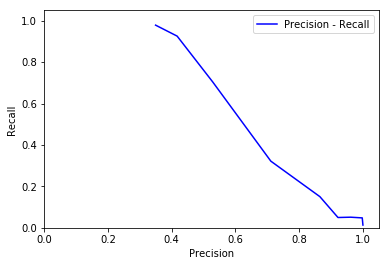

In [12]:
eva = rltk.Evaluation()
for threshold in range(0, 10):
    threshold = float(threshold) / 10
    t = trial.clone() # remember to clone it
    t.evaluate(threshold)
    eva.add_trial(t)
eva.plot_precision_recall().show()

## Machine learning solution

Another approach is using machine learning techniques. [Scikit-learn](http://scikit-learn.org/stable/) is used here (Run `pip install -U scikit-learn` for installation).

### Feature vector

The basic idea to use machine learning is to construct the feature vector of each pair and use it to train a model, then this model can be used to predict whether the input feature vector indicates a pair or not.

In [13]:
tfidf = rltk.TF_IDF()
for r in ds_abt:
    tfidf.add_document(r.id, r.name_tokens)
for r in ds_buy:
    tfidf.add_document(r.id, r.name_tokens)
tfidf.pre_compute()

def generate_feature_vector(r_abt, r_buy):
    # brand
    brand_score = 0.2
    brand_marker = 0
    if r_abt.brand_cleaned and r_buy.brand_cleaned:
        if r_abt.brand_cleaned == r_buy.brand_cleaned:
            brand_score = 1
            brand_marker = 1


    # model 1
    model_score = 0.2
    model_marker = 0
    if r_abt.model_cleaned and r_buy.model_cleaned:
        if r_abt.model_cleaned == r_buy.model_cleaned:
            model_score = 1
            model_marker = 1
        else:
            if len(r_abt.model_cleaned) > len(r_buy.model_cleaned):
                if r_abt.model_cleaned.startswith(r_buy.model_cleaned) \
                        or r_abt.model_cleaned.endswith(r_buy.model_cleaned):
                    model_score = 1
                    model_marker = 1
                else:
                    model_score = rltk.levenshtein_similarity(r_abt.model_cleaned, r_buy.model_cleaned)
            elif len(r_abt.model_cleaned) < len(r_buy.model_cleaned):
                if r_buy.model_cleaned.startswith(r_abt.model_cleaned) \
                        or r_buy.model_cleaned.endswith(r_abt.model_cleaned):
                    model_score = 1
                    model_marker = 1
                else:
                    model_score = rltk.levenshtein_similarity(r_abt.model_cleaned, r_buy.model_cleaned)
            else:
                model_score = 0

    # model 2
    model2_score = rltk.levenshtein_similarity(r_abt.model_cleaned, r_buy.name_suffix)

    # name tokens jaccard
    jaccard_score = rltk.jaccard_index_similarity(r_abt.name_tokens, r_buy.name_tokens)

    tfidf_score = tfidf.similarity(r_abt.id, r_buy.id)

    # price
    if r_abt.price and r_buy.price:
        price_marker = 1
        abt_price = float(r_abt.price)
        buy_price = float(r_buy.price)
        if abt_price == 0 and buy_price == 0:
            price_difference = 0
        else:
            price_difference = float(abs(abt_price - buy_price)) / max(abt_price, buy_price)
    else:
        price_marker = 0
        price_difference = 0

    return [brand_score, brand_marker, model_score, model_marker,
            model2_score, jaccard_score, tfidf_score, price_difference, price_marker]

### Train test split

In [14]:
gt.remove_negatives()
gt_train, gt_test = gt.train_test_split(test_ratio=0.3)

### Generate stratified negatives for ground truth

In order to train a machine learning model, same amount of negatives to positives needs to be given. But how to sample negatives is a problem: random sampling may only give training algorithm very easy-to-detect negatives.

So I'm going to do a stratified sampling. RLTK has a built-in method called `generate_stratified_negatives`. You only need to provide a clustering function and tell RLTK the total number of clusters and the total number of negatives you want, then it generates negatives and picks them based on the positive and negatives ratio of each cluster.

For testing, I want the model to be validated on all possible combination of pairs.

In [15]:
from sklearn.cluster import KMeans

X_km = []
for id_abt, id_buy, _ in gt_train:
    r_abt = ds_abt.get_record(id_abt)
    r_buy = ds_buy.get_record(id_buy)
    X_km.append(generate_feature_vector(r_abt, r_buy))
kmeans_model = KMeans(n_clusters=10, random_state=0).fit(X_km)


def classify(r_abt, r_buy):
    v = generate_feature_vector(r_abt, r_buy)
    cluster_id = kmeans_model.predict([v])[0]
    return cluster_id

gt_train.generate_stratified_negatives(ds_abt, ds_buy, classify, 10, range_in_gt=True, exclude_from=gt_test)
gt_test.generate_all_negatives(ds_abt, ds_buy, range_in_gt=True, exclude_from=gt_train)

### Train and test

After preparation, it's time to train and test model.

In [16]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# train
X, y = [], []
train_pairs = rltk.get_record_pairs(ds_abt, ds_buy, ground_truth=gt_train)
for r_abt, r_buy in train_pairs:
    v = generate_feature_vector(r_abt, r_buy)
    X.append(v)
    y.append(gt_train.get_label(r_abt.id, r_buy.id))

clf = svm.SVC(probability=True)
res = 5
clf = GridSearchCV(clf,
                   {'C' : [i / res for i in range(1, res + 1)], 
                    'gamma' : [i / (100 * res) for i in range(0, res + 1)]},
                  cv=3)
clf.fit(X, y)

# test
trial = rltk.Trial(ground_truth=gt_test)
for r_abt, r_buy in rltk.get_record_pairs(ds_abt, ds_buy, ground_truth=gt_test):
    # ml
    v = generate_feature_vector(r_abt, r_buy)
    vv = clf.predict_proba([v])[0][1]
    trial.add_result(r_abt, r_buy, vv > 0.3,
                     confidence=vv,
                     feature_vector=v)

Though Abt-Buy contains few many-to-many pairs, if I restrict it only to have one-to-one pairs (by using Munkres), false positive drops and F-measure increases. 

In [17]:
for threshold in [round(x * 0.1, 1) for x in range(0, 10)]:
    trial.run_munkres(threshold=threshold)
    trial.evaluate()
    print('threshold:', threshold, 'f-measure:', trial.f_measure)

threshold: 0.0 f-measure: 0.8462709284627092
threshold: 0.1 f-measure: 0.8462709284627092
threshold: 0.2 f-measure: 0.8416149068322981
threshold: 0.3 f-measure: 0.8538587848932677
threshold: 0.4 f-measure: 0.75
threshold: 0.5 f-measure: 0.7252336448598131
threshold: 0.6 f-measure: 0.6666666666666666
threshold: 0.7 f-measure: 0.628099173553719
threshold: 0.8 f-measure: 0.5482456140350878
threshold: 0.9 f-measure: 0.14124293785310732
